In [5]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, color
from skimage.transform import resize
import math
import os

# Specify the directory path
directory_path = './data/downloaded/ericcahan/'

# Get all file names in the directory
file_names = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
print(len(file_names))

62


In [6]:
def get_df_rgb(img):
    image = img
    if isinstance(img, str):
        image = Image.open(img)
    
    n_dims = np.array(image).shape[-1]
    pixel_values = np.array(image).reshape(-1, n_dims)
    
    # Convert normalized values to 0-255 range if necessary
    if pixel_values.max() <= 1.0:
        pixel_values *= 255
    
    r, g, b = pixel_values.T
    return pd.DataFrame({'r': r, 'g': g, 'b': b})

In [22]:
import math

def extract_color_pca_radial(image_name: str):
    file_name = directory_path + image_name
    rgb_values = get_df_rgb(file_name)

    rgb_array = rgb_values.values

    # Initialize the PCA model with 2 components
    pca = PCA(n_components=2)

    # Fit the PCA model to your data
    pca.fit(rgb_array)

    # Transform the RGB values to the first two principal components
    pca_components = pca.transform(rgb_array)

    center = np.mean(pca_components, axis=0)

    # Calculate angles (starting from x axis)
    angles = np.arctan2(pca_components[:,1] - center[1], pca_components[:,0] - center[0])
    angles = np.mod(angles, 2 * np.pi)
    # sort angles
    sorted_indices = np.argsort(angles)

    # reorder angles
    angles = angles[sorted_indices]

    # Calculate distances
    distances = np.sqrt((pca_components[:,0] - center[0])**2 + (pca_components[:,1] - center[1])**2)
    max_distance = np.max(distances)

    # Create lines
    num_segments = 10
    segment_angles = np.linspace(0, 2 * np.pi, num_segments, endpoint=False)
    segment_degrees = np.rad2deg(segment_angles)
    segment_lines = [(center[0], center[1], max_distance * np.cos(a), max_distance *  np.sin(a)) for a in segment_angles]

    # Determin points inside segments
    points_inside_segments = []
    for a1, a2 in zip(segment_angles, np.roll(segment_angles, -1)):
        if a2 > a1:
            points_inside = sorted_indices[(angles >= a1) & (angles < a2)]
        else:
            points_inside = sorted_indices[(angles >= a1) | (angles < a2)]
            if a1 > 2 * np.pi - (a2 - a1):
                points_inside = sorted_indices[(angles >= a1) & (angles < a2) | (angles < a2 - 2 * np.pi)]
        points_inside_segments.append(points_inside)


    segment_colors = []

    # Plot
    # plt.scatter(pca_components_x, pca_components_y, c='black', label="Original data")
    for i, line in enumerate(segment_lines):
        plt.plot([line[0], line[0] + line[2]], [line[1], line[1] + line[3]], color='black')

        # Scatter plot with points inside segments colored based on the segment
        # segment_color = segment_colors(i)
        segment_distances = distances[points_inside_segments[i]]
        colors_inside_segment = rgb_array[points_inside_segments[i]]
        # biggest_distance_idx = np.argmax(segment_distances)
        # segment_color = colors_inside_segment[biggest_distance_idx]
        segment_color = np.mean(colors_inside_segment, axis=0)
        # closet_index = np.argmin(np.linalg.norm(colors_inside_segment - segm, axis=1))
        # farthest_color = np.argmax(colors_inside_segment - center_color, axis=0)
        # print(farthest_color)
        # print(segment_color)
        # segment_color = segment_colors(i)
        if math.isnan(segment_color[0]) or math.isnan(segment_color[1]) or math.isnan(segment_color[2]):
            continue
        print(segment_color)
        segment_colors.append({
            "r": segment_color[0],
            "g": segment_color[1],
            "b": segment_color[2]
        })
    return segment_colors
        

[252.52477817 149.63497007 106.93927117]
hi
hi
hi
[205.0416655    2.15247187   0.89968014]
[248.38109496  25.85909731  19.71046895]
[254.80159301  64.23020721  50.3986705 ]
[254.74361214  74.23198297  57.37415375]
[254.71876551  80.71429861  62.26643505]
[254.7982419  107.01721926  78.80477334]
{"Palm Beach, FL - Sunset 6:33pm.jpg": [{"r": 252.52477817249826, "g": 149.63497007153632, "b": 106.93927117296867}, {"r": 205.0416654976011, "g": 2.1524718722819225, "b": 0.8996801436547797}, {"r": 248.38109496301945, "g": 25.859097307552883, "b": 19.71046895376373}, {"r": 254.80159300515032, "g": 64.23020721044436, "b": 50.39867049946101}, {"r": 254.74361214238917, "g": 74.23198296571304, "b": 57.37415374535925}, {"r": 254.71876551008438, "g": 80.71429860578442, "b": 62.26643504940667}, {"r": 254.79824190223994, "g": 107.0172192571764, "b": 78.80477334461719}]}


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


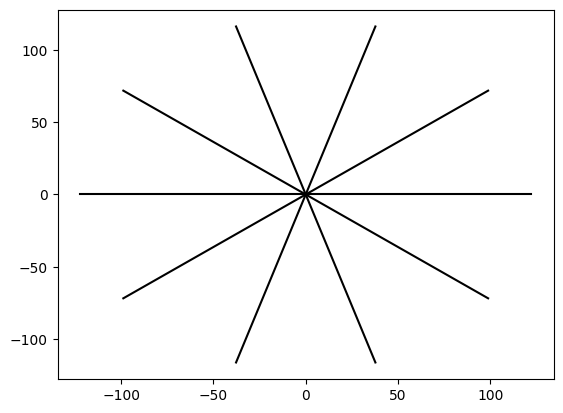

In [23]:
color_data = {}

for file_name in file_names:
    color_data[file_name] = extract_color_pca_radial(file_name)

# color_data[file_names[10]] = extract_color_pca_radial(file_names[10])
import json

# Convert the dictionary to a JSON string
json_data = json.dumps(color_data)

# Print the JSON string
print(json_data)

# Save the JSON string to a file
with open("data.json", "w") as json_file:
    json.dump(color_data, json_file)